

# CNN e PokeGAN - Progetto per l'esame del corso di Machine-Learning e applicazioni
#### Matteo Robbiati, matricola 960979

## Indice 

- (1) preparazione del notebook e caricamento dei pacchetti utilizzati;
- (2) sistemazione dei dati e image preprocessing;
- (2.1) data augmentation e metodo `flow_from_directory`;
- (3) cenni alla teoria delle reti convoluzionali;
- (3.1) la scelta dei parametri;
- (3.2) addestramento della CNN;
- (4) generare nuove immagini: GAN;
- (4.1) addestramento della GAN;
- (4.2) riconoscimento dei pokemon generati.

## Introduzione

Assumiamo di avere uno spazio degli **input** $\vec{x}$, $p-$dimensionale e uno spazio degli **output**, $y$, che prendiamo monodimensionale per semplicità. 
Assumiamo inoltre che esista una relazione tra $\vec{x}$ e $y$, che chiamiamo $f$, tale che

$$ y = f(\vec{x})+\epsilon, $$ 

dove ho indicato con $\vec{w}$ il vettore contenente gli eventuali parametri da cui $f$ dipende.

Ciò che il Machine-Learning si propone di fare, in linea con l'analisi statistica di un campione, consiste nel trovare un modello che sappia approssimare nel modo migliore possibile la legge vera (se esiste) che lega le variabili di input a quelle di output:

$$ \hat{y}=\hat{f}(\vec{x}|\hat{\vec{w}}), $$ 

dove ho indicato con il cappuccio ciò che viene stimato (i parametri e, di conseguenza, la funzione $f$.) Per fare questo occorre scegliere il tipo di modello teorico che si adotta e, in seguito, ricavare la stima migliore dei parametri da cui dipende, tramite l'ottimizzazione di una funzione di costo $\mathcal{C(\vec{y},\hat{\vec{y}})}$.

<hr>

Nel caso che ho affrontato in questo progetto i dati di input sono immagini di pokemon presentate su tre canali (RGB) di dimensione $(64\times 64)$ in pixel. Ho addestrato una rete neurale convoluzionale (CNN) a prevedere la classe (ossia il nome) del pokemon rappresentato in figura.

<hr>

In una seconda parte del progetto ho costruito e addestrato due reti generative avversarie (GAN), con l'intenzione di generare nuove immagini di pokemon da sottoporre alla CNN addestrata in precedenza. Ho implementato questi algoritmi ispirandomi ai lavori di Goodfellow et al. [1], alle lezioni svolte in classe [5] e al corso del professor Jeff Heaton, docente in McKelvey School of Engineering, Whashington University in St. Louis [3].

#### Appunto sulla grafica del notebook

Per rendere più scorrevole la lettura ho nascosto alcune celle contenenti codice o testo di input che ho ritenuto non necessari alla lettura. Per mostrarli è sufficiente cliccare sui bottoni relativi ai singoli blocchi.

## 1. Caricamento dei pacchetti e preparazione del notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import shutil
import imghdr
from IPython.display import clear_output

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Activation, Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.python.keras.optimizer_v2.adam import Adam
from keras.layers.merge import concatenate

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import time


#per evitare che escano avvisi relativi all'assenza sulla mia macchina della GPU

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    

In [2]:
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tqdm import tqdm
import time

## 2. Sistemazione dei dati e image preprocessing


### Il Dataset

I dati che ho utilizzato sono stati raccolti da Lance Zhang e pubblicati su Kaggle nel 2019. Il catalogo contiene 150 cartelle, i cui nomi corrispondono ad altrettanti pokemon. In ciascuna cartella sono contenute dalle 25 alle 50 immagini del pokemon da cui la cartella prende il nome. Le immagini sono di varie dimensioni e non tutte si trovano in formato RGB.

### Image Preprocessing

In [3]:
#output della barra temporale che segnala lo svolgimento del processo

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

#dimensioni delle immagini processate

GENERATE_RES = 2 
GENERATE_SQUARE = 32 * GENERATE_RES 
IMAGE_CHANNELS = 3

#dimensione dello spazio latente, serve per il generatore nella GAN
z_dim = 100

#percorso file del dataset iniziale
poke_path = 'PokeData/dataset'

Per addestrare la GAN mi è utile avere tutte le immagini raccolte in una sola cartella e presentate in un formato unico. In questo caso ho voluto predisporle in una `lista`, in cui ogni elemento è un'immagine tradotta in un vettore di dimensioni (64,64,3), rispettivamente pixel in altezza, larghezza e canali cromatici. Per l'addestramento della CNN ho invece sfruttato la configurazione originale del dataset, utilizzando il metodo `flow_from_directory`, di cui parlerò poco più avanti.

<hr>

Nel raggruppamento delle immagini ho scartato i file di tipo *.svg, non potendo essere aperti dal pacchetto `Image` di `PIL`.

### Costruisco la lista di dati per il training della GAN

In [46]:
import time

print("Loading training images...")
start = time.time()

i=0

training_data = []
y_data = []

for directory in(os.listdir(poke_path)):
    for filename in(os.listdir(poke_path+'/'+directory)):
        if (imghdr.what(poke_path+'/'+directory+'/'+filename)=='jpeg' or imghdr.what(poke_path+'/'+directory+'/'+filename)=='png'):
            path = os.path.join(poke_path+'/'+directory,filename)
            image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS).convert('RGBA')
           # image.load() # required for png.split()
            background = Image.new("RGBA", image.size, (255, 255, 255))
           # image = Image.alpha_composite(background, image).convert('RGB')
            image = image.resize((64,64))
            training_data.append(np.asarray(image))
            y_data.append(directory)
        else:
            continue

training_data = np.reshape(training_data,(-1,64,64,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 255
elapsed = time.time()-start
print (f'Image preprocess time: {hms_string(elapsed)}')


Loading training images...
Image preprocess time: 0:01:05.46


### Visualizziamo alcune immagini

Stampo qui di seguito nove immagini estratte casualmente dal campione utilizzato come insieme di training.

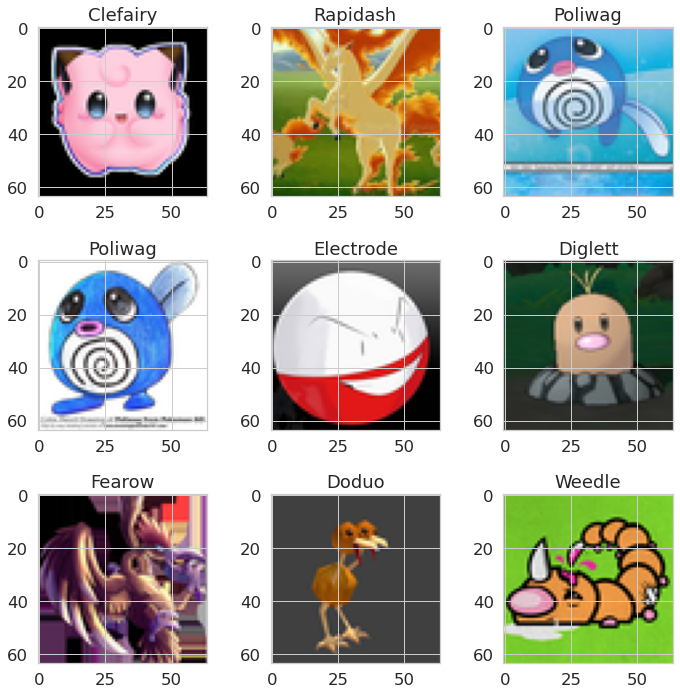

In [47]:
N = len(training_data)

plt.figure(figsize=(10,10))

for k in range(9):
    rnd = random.randint(1,N)
    plt.subplot(3,3,k+1)
    plt.title(y_data[rnd])
    plt.imshow(training_data[rnd])

plt.tight_layout()

### Preparo cartelle per training e test della CNN


Anche in questo passaggio rimuovo dalle cartelle i file *.svg, selezionando solo immagini di tipo *.jpg e *.png

<hr>

In [49]:
#creo la cartella scarti e sposto in quest'ultima i file di tipo *.svg
os.system('mkdir Scarti')

count = 0

for dir in os.listdir(poke_path):
    for img in os.listdir(poke_path+'/'+dir):
        if(imghdr.what(poke_path+'/'+dir+'/'+img)!='jpeg' and imghdr.what(poke_path+'/'+dir+'/'+img)!='png'):
            os.system('mv '+poke_path+'/'+dir+'/'+img+' Scarti')
            count = count + 1

print('Sono stati scartati ', count, 'elementi dal dataset iniziale.')

Sono stati scartati  0 elementi dal dataset iniziale.


In [50]:
#creo cartella per i dati di training e quella per i dati di test e validazione
os.system("mkdir PokeTrain")
os.system("mv PokeData/dataset/* PokeTrain/")

os.system("mkdir PokeTest")
os.system("cp -r PokeTrain/* PokeTest/")

#svuoto quella di test, selezionerò in seguito alcuni dati dalla cartella di training
os.system("find PokeTest/ -name '*.*' -type f -delete")

#percorsi file per accedere a dati di training e di test
train_path = 'PokeTrain'
test_path = 'PokeTest'

print('Sistemazione delle directory terminata! Puoi procedere con la selezione del set di test')

Sistemazione delle directory terminata! Puoi procedere con la selezione del set di test


#### Preparo cartelle di test, rimuovendo elementi dalle cartelle del training

In [51]:
def SetTest(pokemon,train_path,test_path):
    
    pop = os.listdir(train_path+'/'+pokemon)
    test_data = random.sample(pop,8)
    for f in test_data:
        os.system('mv '+train_path+'/'+pokemon+'/'+f+' '+test_path+'/'+pokemon+'/')

In [ ]:
for poke in os.listdir(train_path):
    SetTest(poke,train_path,test_path)

### Data augmentation

Nel Machine-Learning può essere utile adottare strumenti tramite cui aumentare il numero di dati a disposizione. La libreria Keras fornisce, nel pacchetto `preprocessing.image`, il metodo `ImageDataGenerator`, tramite cui è possibile generare immagini fittizie, costruite a partire da un dato, modificandone in modo arbitrario la struttura in pixel.

La peculiarità di `ImageDataGenerator` è che non aumenta il numero di dati a disposizione; ne crea di nuovi a partire da quelli forniti e li utilizza al posto di quelli originali; 

In [13]:
                                                              #imposto i parametri
image_gen = ImageDataGenerator(rotation_range=20,             #rotazione
                               rescale = 1./255,              
                               width_shift_range=0.1,         #traslazioni
                               height_shift_range=0.1,
                               shear_range=0.2,               #shear
                               zoom_range=0.15,               #dilatazione o contrazione
                               horizontal_flip=True,
                               fill_mode='nearest')

In [14]:
image_shape = (64,64,3)

### Costruisco set di training e test 

Costruisco i set di training e test che utilizzo per fare l'addestramento della rete sfruttando il metodo `image_gen.flow_from_directory()`. 

In [153]:
batch_size = 27    #creo batch che sia quanto più possibile multiplo della cardinalità del set di test
                   #così da non perdere elementi usati per validare
    
print('Generazione dei set di training e di test')
print('  ')


train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')


test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='categorical')


Generazione dei set di training e di test
  
Found 5623 images belonging to 150 classes.
Found 1191 images belonging to 150 classes.


## 3. Le reti neurali convoluzionali (CNN)

Le reti neurali convoluzionali sono reti neurali Feed Forward che sfruttano l'operazione di convoluzione per imparare ad estrarre pattern dai dati di input, così da poter fare regressione o classificazione. 
Ho scelto di utilizzare una rete convoluzionale perché, come visto a lezione, si tratta di uno strumento adatto al riconoscimento e alla classificazione di immagini. Inoltre, il meccanismo su cui le CNN basano l'ottimizzazione delle loro performance è la **convoluzione**. Questa operazione diventa estremamente utile nel caso in cui i dati siano presentati in forma matriciale, come nel caso delle immagini.

<hr>

Date $x(t)$ e $w(t)$ funzioni della variabile $t$, si definisce convoluzione di $x$ e $w$ la seguente operazione: $$ S(t) \equiv (x*w)(t)=\int x(t-a)w(a)\mathrm{d}a.$$ 

Nel caso della convoluzione di un dato nella forma di immagine con un `kernel` (in questo caso d'esempio $3\times 3$) scelto appositamente è comodo definire la stessa operazione in termini di singola componente della matrice: $$ S(i,j) = (x*w)(i,j) = \sum_{n,m=-1,0,1} x(i-m,j-n)w(m,n), \qquad i,j=1,...,64$$
in cui compare l'esplicita dipendenza dai suoi indici. L'applicazione pratica di una convoluzione tra immagine e filtro è dunque un prodotto riga per colonna di matrici, il cui risultato consiste in una modifica dipendente dal filtro dell'immagine iniziale. Nella relazione precedente sono ammesse operazioni su elementi che "escono dai margini" della matrice di input; questo fenomento viene tipicamente risolto collocando attorno all'immagine una zona cuscinetto (*Zero Padding*), righe e colonne fittizie riempite con valori nulli.

<img src='convoluzione.gif'>

**Figura animata:** in figura è mostrato il ruolo del cuscinetto di zeri nell'operazione di convoluzione.

### Modello sequenziale della CNN 

Come classificatore costruisco una rete neurale convoluzionale; per farlo utilizzo il metodo `Sequential()` fornito da <font color='dark orange'>**Keras**</font>. Nel concatenamento ho inserito diversi tipi di **layers**:
- `Conv2D`: la matrice di input viene convoluta con un *kernel* bidimensionale (poiché si tratta di immagini) per il quale è possibile impostare diversi parametri: <font color='dark orange'>**filters**</font> indica la dimensione dello spazio degli output, <font color='dark orange'>**padding**</font> posto uguale a 'same' indica la scelta di utilizzare un cuscinetto a contorno della matrice di input (zero padding visto a lezione), <font color='dark orange'>**activation**</font> indica la scelta fatta come funzione di attivazione per il layer in questione.
- `MaxPool2D`: implementa l'operazione di *pooling* per input bidimensionali. In questo caso il parametro <font color='dark orange'>**pool_size**</font>=(2,2) indica che, nell'applicazione del pooling, la selezione del massimo viene fatta su una griglia di dimensione (2,2).
- `Flatten`: riorganizza i pixel provenienti dal layer precedente, disponendoli lungo un array monodimensionale.
- `Dense`: svolge una convoluzione in stile "Feed-Forward"; ogni neurone dello strato dense è collegato ad ogni elemento dell'output fornito dal layer precedente. I parametri forniti sono <font color='dark orange'>**units**</font>, che indica la dimensione dell'output e <font color='dark orange'>**activation**</font> che indica la scelta della funzione di attivazione nel processo di convoluzione.


Come funzione di costo ho selezionato `categorical_crossentropy`, utile per i problemi di classificazione a multi-classe, la quale restituisce un vettore di output contenente valore uno nella classe associata all'input.

Come ottimizzatore ho deciso di utilizzare ADAM, il più largamente utilizzato per ottimizzare algoritmi nel Machine-Learning. Oltre al parametro di *stepsize*, ADAM richiede che vengano introdotti altri tre parametri ($\beta_1,\beta_2$, $\epsilon$), corrispondenti ai tassi di decadimento esponenziale con cui contribuiscono i momenti algebrici di primo e secondo ordine del gradiente e ad un parametro dal valore molto piccolo che viene introdotto per evitare che il denominatore nell'espressione del passo si annulli.
In questo caso ho deciso di affrontare più nel dettaglio lo studio dei parametri $\eta$ e $\beta_1$. `Keras` pone in automatico $\beta_2=0.99$ e $\epsilon=10^{-7}$ se non specificato.


<hr>

Riporto qui di seguito la struttura della rete convoluzionale che ho utilizzato e, successivamente, i risultati di ottimizzazioni superficiali che ho deciso di studiare così da selezionare il set ottimale di parametri iniziali per $\eta$ e $\beta_1$.

In [56]:
def crea_CNN(eta, lmbd, beta):

    model = Sequential(name='PokeCNN')

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',input_shape=image_shape,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(1024,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dropout(rate=0.25))
    model.add(Dense(512,activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(150,activation='softmax', kernel_regularizer=regularizers.l2(lmbd)))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=eta, beta_1=beta), metrics=['accuracy'])

    return model

test_cnn = crea_CNN(0.001, 0.0, 0.5)
test_cnn.summary()

Model: "PokeCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 128)       1475

### Esploro superficialmente lo spazio dei parametri

Per come ho costruito la rete occorre inizializzare i parametri $\eta$ e $\beta_1$ e scegliere un valore per l'eventuale parametro di regolarizzazione $\lambda$, che ho voluto inserire negli strati in cui si opera la convoluzione. 

Per effettuare una scelta ho deciso di provare ad addestrare la CNN utilizzando set di training e test fissati su varie combinazioni di parametri per 15 epoche. Ho deciso di affidarmi ai valori che, nello stesso tempo di addestramento, avrebbero fornito i valori di accuratezza maggiore (l'accuratezza, `accuracy`, è definita come frazione dei dati classificati in modo corretto). Raccolgo nei seguenti vettori i valori scelti per questa parte di analisi: 

$$ \vec{\eta}_0 = [10^{-5}, 0.001, 0.1] \qquad \quad \vec{\beta}_0 = [0.05, 0.5, 0.9], \qquad \quad \vec{\lambda} = [0.0, 10^{-5}, 0.0005]. $$


Per quanto riguarda la scelta di $\eta$ e $\lambda$ ho effettuato ulteriori test prima di svolgere l'analisi che segue, che è la parte finale del processo di scelta.

#### Combinazioni di $\eta$ e $\beta$

Per prima cosa ho studiato diverse combinazioni dei parametri da cui dipende ADAM. La scelta è ricaduta sulla combinazione $\eta=0.001, \beta=0.5$, in accordo con i risultati riportati nella figura seguente.

<img src="eta_beta.png">


#### Combinazioni di $\eta$ e $\lambda$

In secondo luogo ho svolto la stessa analisi coinvolgendo $\eta$ e $\lambda$, per i quali, come si evince dalla figura che segue, ho scelto i valori $\eta=0.001$, $\lambda=0.0$.

<img src="eta_lambda.png">

In conclusione, ho stabilito la configurazione iniziale della rete: `crea_CNN(0.001,0.0,0.5)`.

### Addestramento della CNN

Definiti i valori ottimali per inizializzare l'ottimizzazione, ho addestrato la rete per 150 epoche, con l'intento di trovare il giusto compromesso tra **bias** e **varianza** nel modello, così da evitare l'overfitting.

In [65]:
eta_best = 0.001
lambda_best = 0.0
beta_best = 0.5

cnn = crea_CNN(eta_best, lambda_best, beta_best)

In [67]:
results = cnn.fit(train_image_gen,epochs=60,validation_data=test_image_gen)
#cnn.save_weights('cnn_weights.h5')

Epoch 1/60
209/209 [==============================] - 115s 546ms/step - loss: 4.6126 - accuracy: 0.0359 - val_loss: 5.8845 - val_accuracy: 0.0109
Epoch 2/60
209/209 [==============================] - 112s 536ms/step - loss: 3.7247 - accuracy: 0.0987 - val_loss: 3.7209 - val_accuracy: 0.1050
Epoch 3/60
209/209 [==============================] - 112s 533ms/step - loss: 3.2847 - accuracy: 0.1522 - val_loss: 3.1286 - val_accuracy: 0.1914
Epoch 4/60
209/209 [==============================] - 113s 539ms/step - loss: 3.0016 - accuracy: 0.2155 - val_loss: 2.8966 - val_accuracy: 0.2552
Epoch 5/60
209/209 [==============================] - 112s 534ms/step - loss: 2.7530 - accuracy: 0.2579 - val_loss: 2.8965 - val_accuracy: 0.2628
Epoch 6/60
209/209 [==============================] - 114s 543ms/step - loss: 2.5942 - accuracy: 0.2959 - val_loss: 2.8979 - val_accuracy: 0.2779
Epoch 7/60
209/209 [==============================] - 112s 537ms/step - loss: 2.3766 - accuracy: 0.3482 - val_loss: 3.2714 -

Epoch 57/60
209/209 [==============================] - 134s 642ms/step - loss: 0.6189 - accuracy: 0.8177 - val_loss: 1.5942 - val_accuracy: 0.6591
Epoch 58/60
209/209 [==============================] - 134s 640ms/step - loss: 0.5897 - accuracy: 0.8239 - val_loss: 1.6135 - val_accuracy: 0.6364
Epoch 59/60
209/209 [==============================] - 137s 655ms/step - loss: 0.5657 - accuracy: 0.8286 - val_loss: 1.7072 - val_accuracy: 0.6297
Epoch 60/60
209/209 [==============================] - 134s 641ms/step - loss: 0.6186 - accuracy: 0.8122 - val_loss: 1.7307 - val_accuracy: 0.6356


#### Carico/scarico i pesi della rete 

In [170]:
#cnn.save_weights('Weights/cnn_weights.h5')
cnn.load_weights('Weights/cnn_weights.h5')

In [ ]:
plt.figure(figsize=(10,7))
time = np.arange(1,100,100)

plt.title('Addestramento per 60 epoche, $\eta=0.001$ e $beta = 0.5$')

train_loss = results.history['loss']
test_loss = results.history['val_loss']
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

test_acc = results.history['val_accuracy']
train_acc = results.history['accuracy']
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')

plt.xlabel('Epoche')
plt.ylabel('Funzione di Costo')

plt.legend()
plt.savefig('big_train.png')
plt.show()

<img src='2_fit.png'>

Come si vede nella figura a sinistra dagli andamenti del valore della funzione di costo e del tasso di accuratezza relativi al training, l'addestramento successivo all'epoca 50 porta il modello verso una condizione di overfitting.  Inoltre, si nota che la sequenza dei valori della funzione di costo calcolata nel tempo è molto più oscillante nel caso del set di test, come ci si aspetta. L'accuratezza nelle previsioni effettuate sul set di test si assesta attorno al 60%, l'ultimo valore riportato nell'addestramento è 61.37%. Alcune considerazioni:
- le immagini raccolte nel dataset sono molto diverse tra loro, anche nel caso corrispondano allo stesso pokemon. Un fattore sicuramente non irrilevante è la presenza di background nelle immagini, di cui riporto un esempio al termine del paragrafo; questo rende più complicata la classificazione;

<img src='charizard.png' style="width: 500px;">


- il numero di classi che compongono lo spazio degli output è 150, il che rende il problema di classificazione non banale;
- il grafico relativo al training della CNN evidenzia un chiaro comportamento di overfitting della rete. Nonostante questo, il valore della funzione di costo calcolata sul set di test non aumenta in modo evidente. Cionostante, come configurazione ottimale della rete ho deciso di salvare i pesi corrispondenti all'epoca 60, garantendo un livello di accuratezza paragonabile alla configurazione registrata in epoca 150. 



### Test della CNN 

Per utilizzare la CNN come classificatore di pokemon ho scritto due metodi: `predict_pokemon_by_url` e `predict_pokemon`. Il primo lo utilizzo per vedere che previsione viene associata all'immagine di un pokemon estratta dal web, il secondo lo utilizzerò in seguito per prevedere che pokemon viene associato all'immagine prodotta dalla GAN.

In [75]:
import urllib.request

#immagini di Vaporeon, Flareon e Dratini estratte dal web

img1 = 'https://media.izi.travel/4e9d2b2c-83c3-4a84-8675-7cc276270305/7d87b069-3e76-4427-ad38-e6dd7c3eb2b6_800x600.jpg'   
img2 = 'https://i.pinimg.com/originals/a6/29/fa/a629fa72f09a3e146bd209c60b4f3b16.jpg'                                     
img3 = 'https://www.poketown.net/public/poketown/media/global-link/147.png'                                               

In [158]:
def predict_pokemon_by_url(cnn, img_url):

    # apro url
    url = img_url
    test_image_path = urllib.request.urlopen(url)

    # adatto le dimensioni dell'immagine al formato 64x64 richiesto dalla rete
    img = Image.open(test_image_path)
    img = img.resize((64,64))

    # mostro l'immagine
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.show()

    # elimino eventuali trasparenze o canali diversi dagli standard RGB

    img = np.array(img)
    if img.shape[2] != 3:
        img = img[:,:,:3]

    # converto in array, normalizzo ed espando le dimensioni

    img = img/255
    my_img_array = np.expand_dims(img,axis=0)

    # predizione del modello 
    # in ordine decrescente di probabilità di classificazione 
    pred_class = np.argmax(cnn.predict(my_img_array),axis=-1)
    poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
    #output della scelta
    print('Rete Neurale Convoluzionale sceglie: ', poke_class[pred_class[0]], '!!') 
    
    
def predict_pokemon(cnn, img):

    # mostro l'immagine
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.show()

    my_img_array = np.expand_dims(img,axis=0)

    # predizione del modello 
    # in ordine decrescente di probabilità di classificazione 
    pred_class = np.argmax(cnn.predict(my_img_array),axis=-1)
    poke_class = {value:key for key,value in train_image_gen.class_indices.items()}
    #output della scelta
    print('Rete Neurale Convoluzionale sceglie: ', poke_class[pred_class[0]], '!!') 


In [ ]:
predict_pokemon_by_url(cnn, img1)
predict_pokemon_by_url(cnn, img2)
predict_pokemon_by_url(cnn, img3)

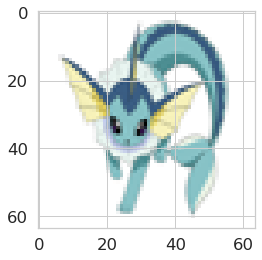

Rete Neurale Convoluzionale sceglie:  Vaporeon !!


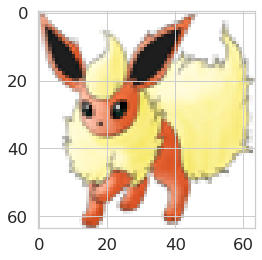

Rete Neurale Convoluzionale sceglie:  Flareon !!


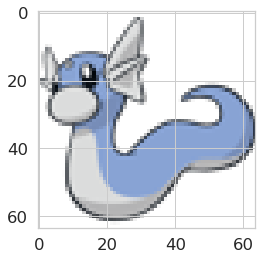

Rete Neurale Convoluzionale sceglie:  Dratini !!


In [78]:
predict_pokemon_by_url(cnn, img1)
predict_pokemon_by_url(cnn, img2)
predict_pokemon_by_url(cnn, img3)

##  3. Generare nuove immagini: GAN

Le GAN sono state presentate nel 2014 da Goodfellow et al. [1] come strumento per generare in modo ottimale immagini che siano attribuibili ad un determinato campione (o, in modo ancor più generale, alla distribuzione teorica da cui quello stesso campione è stato estratto). Una GAN è strutturata in due parti, un generatore (G) e un discriminatore (D). $G$ e $D$ sono tipicamente reti neurali (MLP) e svolgono due ruoli differenti:

- il **generatore**, $G$, genera casualmente nuove immagini dimensionalmente compatibili con il campione di dati;
- il **discriminatore**, $D$, riceve l'immagine generata da $G$ e stabilisce se è stata estratta dal campione o simulata dal generatore.

In pratica $D$ deve capire se l'immagine che analizza è appartenente al campione o generata da $G$ e $G$ deve tentare di ingannare $D$. 

<hr>

Assumiamo che un campione di immagini sia estratto da una p.d.f. $\rho_{data}$, che ne descrive la distribuzione in $X \subseteq R^p$ . Inoltre, associamo allo spazio delle immagini uno spazio latente, sul quale apportiamo un rumore. Chiamiamo $Z$: $Z\subseteq R^d$ tale spazio.

Introduciamo ora due reti neurali, la prima, $G\equiv G(\vec{z}\in Z ; \vec{\theta}_g): R^d \to R^p$ che, presi elementi dello spazio latente genera immagini compatibili con lo spazio delle $\vec{x}$. La seconda, $D\equiv D(\vec{x}\in X; \vec{\theta}_d):R^p\to [0,1]$ che, preso un elemento dimensionalmente compatibile con $X$, restituisce un output monodimensionale. 

Chiamiamo $\rho_{data}$ e $ \rho_g$ rispettivamente le distribuzioni di estrazione dei dati e di generazione di immagini tramite $G$.
$D(\vec{x})$ rappresenta la probabilità che il dato $\vec{x}$ sia stato estratto da $\rho_{data}$ piuttosto che $\rho_{g}$.




<hr>

L'ottimizzazione di questa struttura, come spiegato in [1], è sviluppata in modo tale sia massimizzata la probabilità che $D$ assegni la classe corretta e, al contempo, G viene addestrato per minimizzare la probabilità che il discriminatore ne classifichi gli output come "FALSO" $\log(1-D(z))$:

$$ \min_{G}\max_{D}\biggl[ \mathbb{E}_{x\sim p_{data}}\bigl[\log(D(x))\bigr] + \mathbb{E}_{z\sim p_{gen}} \bigl[ (1-\log(D(G(z))))\bigr]\biggr]. $$

Sempre nella [1] è dimostrato che esiste un punto di ottimo globale per l'addestramento e corrisponde al caso in cui, per $\rho_g = \rho_{data}$ si ha che $D^*(\vec{x})=0.5$.


#### Definizione di funzioni utili

In [61]:
#funzione per generare un mini-batch dal set di training
def genera_batch(batch_len):
    idx = np.random.randint(1,N,batch_len)
    batch = list()
    for i in idx:
        batch.append(training_data[i])
    return batch

#funzione per generare un seme nello spazio latente, compatibile con input del generatore
def genera_seme(num_semi):
    seeds = tf.random.normal([num_semi, z_dim])
    return seeds

#funzione per generare un mini-batch di immagini false, generate da GEN a partire dai semi
def genera_fake(n_samples, gen):
    seeds = genera_seme(n_samples)
    x_fake = gen.predict(seeds)
    return x_fake


# output grafico delle immagini e salvataggio sul drive nei casi in cui lavoravo con Google Colab
def stampa_pokemon(gen, test_input, epoch, namedir):

    immagini = gen(test_input, training=False)

    dim = immagini.shape[0]
    
    os.system('mkdir ./drive/MyDrive/Images/'+namedir)

    fig = plt.figure()    
    for i in range(dim):
        img = keras.preprocessing.image.array_to_img(immagini[i])
        plt.subplot(int(np.sqrt(dim)), int(np.sqrt(dim)), i+1)
        plt.imshow(img)
        plt.axis('off')

    if(epoch!=-1): # -1 indica che il processo di training è terminato
        fig.suptitle('Pokemon generati in epoca {:d}'.format(epoch), fontsize=18)
        plt.savefig('./drive/MyDrive/Images/'+namedir+'/numbers_epoch_{:04d}.png'.format(epoch))
    else:
        fig.suptitle('Pokemon al termine del training', fontsize=18)
        plt.savefig('./drive/MyDrive/Images/numbers_after_training.png')
    plt.show()

In [83]:
def test(batch_size):
    
    x_fake = genera_fake(1786, pokeGEN)
    x_disc = np.concatenate((x_test, x_fake))     #ne faccio un batch unico, mezzo generato e mezzo vero
    y_ones = np.ones(1786)                        #output 1 per i dati veri
    y_zeros = np.zeros(1786)                      #output 0 per i dati falsi
    targets = np.concatenate((y_ones, y_zeros))
    x_seeds = genera_seed_generatore(1786)
    
    print("----- Test -----")
    print("Discriminatore: ")
    loss_disc = pokeDISC.evaluate(x_disc, targets, batch_size)
    print("GAN: ")
    loss_gan = GAN.evaluate(x_seeds, y_ones)
    
    return loss_disc, loss_gan

100%|█████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 11.56it/s]


### Generatore, discriminatore e GAN

Nella cella seguente ho definito le strutture di generatore, discriminatore e GAN. Le mie scelte sono il risultato dello studio del codice fornito dai tutorial ufficiali di `Keras` per l'implementazione di GAN e dei codici pubblici del professor Jeff Heaton. I parametri utilizzati negli ottimizzatori li ho scelti dopo qualche tentativo.

<hr>

Anche per questa seconda parte del progetto ho scelto di utilizzare ADAM come ottimizzatore. Per quanto riguarda la funzione di costo, invece, ho selezionato `binary_crossentropy`, pensata appositamente per problemi di classificazione binaria (in questo caso VERO/FALSO).

In [25]:
def generatore(z_dim, channels):
    
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=z_dim))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def discriminatore(input_shape, eta=0.0002, beta=0.5):
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten()) 
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=eta, beta_1=beta)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model


#la GAN è quindi una semplice sequenza di G+D, 
#se uso compile() sulla GAN, eseguo l'operazione sull'intero blocco

def pokeGAN(disc, gen, eta=0.0001, beta=0.5):    
    
    model = models.Sequential()
    model.add(gen)
    model.add(disc)
    
    opt = optimizers.Adam(learning_rate=eta, beta_1=beta)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [84]:
def generatore(z_dim, channels):
    
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=z_dim))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

def discriminatore(input_shape, eta=0.001, beta=0.5):
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu'))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten()) 
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=eta, beta_1=beta)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model


def pokeGAN(disc, gen, eta=0.001, beta=0.5):    
    
    model = models.Sequential()
    model.add(gen)
    model.add(disc)
    
    opt = optimizers.Adam(learning_rate=eta, beta_1=beta)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Metodo per addestrare la GAN

Come descritto in [1], il training di una GAN viene suddiviso in due parti: per un numero stabilito di epoche si allena per $K$ volte il discriminatore (nel mio caso ho scelto K=3) e una volta la GAN, avendo cura che in questo secondo passaggio i pesi del discriminatore siano congelati. Al termine del procedimento (nel corso di 1 epoca) ricarico i pesi aggiornati dopo il primo dei $K$ cicli di addestramento del discriminatore: questo procedimento è utile per evitare che il generatore si concentri in modo particolare su una singola classe.

In [ ]:
def train(gen, disc, gan, epochs, batch_size, K):   
    
    #genero 36 semi nello spazio latente, corrispondenti ad altrettante immagini
    #che userò per controllare l'evolversi delle capacità del generatore
    seeds_test = genera_seed_generatore(36)
    
    # vettori in cui salvo le funzioni costo valutate step by step (per studio approfondito)
    disc_loss_train = np.zeros(epochs)
    gan_loss_train = np.zeros(epochs)
    
    disc_loss_test = np.zeros(epochs)
    gan_loss_test = np.zeros(epochs)
    
    y_ones = np.ones(batch_size)                    #quelle generate le segno con 1
    y_zeros = np.zeros(batch_size)                  #quelle vere con 0
    targets = tf.concat([y_ones, y_zeros], axis=0)  #concateno i target nell'ordine delle img
    
    n_batch = int(N/batch_size)

    #QUANDO USO COLAB: PER SALVARE LE IMMAGINI DIRETTAMENTE NELLE CARTELLE DRIVE
    #os.system('mkdir ./drive/MyDrive/POKE')
    #os.system('mkdir ./drive/MyDrive/POKE/Weights')
    
 
    for i in tqdm(range(epochs)):
        clear_output(wait=True)
        start = time.time()
                
        print(" In corso lo svolgimento dell'epoca ", i+1, "/", epochs, "!")

        for i_batch in tqdm(range(int(n_batch))):
            print("Batch %d/%d" %(i_batch+1,n_batch), end="\r")
            
            disc.trainable = True          #i pesi del discriminatore possono aggiornarsi
            
            for k in range(K):             #alleno K volte D e 1 volta G
                                           #genero batch di dati metà falsi e metà veri
                x_fake = genera_fake(batch_size, gen)
                batch = genera_batch(batch_size)
                
                batch = tf.concat([batch, x_fake], axis=0)   #ne faccio un batch unico

                #
                # training vero e proprio del discriminatore
                if (k==0):
                    hist = disc.train_on_batch(batch, targets)
                    disc_loss_train[i] += hist/n_batch
                    disc.save_weights('./drive/MyDrive/POKE/Weights/disc_weights_k=0.h5')
                else:
                    disc.train_on_batch(batch, targets)
            
            # semi per addestrare il generatore
            x_seeds = genera_seed_generatore(batch_size)
            
            # training GAN, generatore Sì, Discriminatore No            
            disc.trainable = False 
                    
            hist = gan.train_on_batch(x_seeds, y_ones)
            gan_loss_train[i] += hist/n_batch
            
            disc.load_weights('./drive/MyDrive/POKE/Weights/disc_weights_k=0.h5')
            pass
            
        plotta_immagini_gen(gen, seeds_test, i+1, 'GColab_Run_POKE')
        
        disc_loss_test[i], gan_loss_test[i] = test(batch_size)
           
        print("Tempo epoca = ", time.time() - start)
       
        # salviamo i pesi delle reti
        if((i+1) % 10 == 0):
            gan.save_weights('./drive/MyDrive/POKE/Weights/gan_weights_epoch_{:03d}.h5'.format(i+1))
            gen.save_weights('./drive/MyDrive/POKE/Weights/gen_weights_epoch_{:03d}.h5'.format(i+1))
            disc.save_weights('./drive/MyDrive/POKE/Weights/disc_weights_epoch_{:03d}.h5'.format(i+1))
        
        plt.pause(2)
        
    return disc_loss_train, gan_loss_train, disc_loss_test, gan_loss_test

### Esempio di costruzione degli elementi della GAN

Di seguito costruisco discriminatore, generatore e GAN. Per visualizzare l'effetto del training sulla rete
- genero un'immagine con il generatore non addestrato;
- carico i pesi relativi all'addestramento di 150 epoche con K=3 effettuato;
- genero un'immagine con il generatore addestrato.

In [92]:
input_shape=(64,64,3)

In [144]:
pokeGEN = generatore(z_dim,3)
pokeDISC = discriminatore(input_shape)
GAN = pokeGAN(pokeDISC, pokeGEN)

In [ ]:
epochs = 150
batch_size = 27

hist_disc, hist_gan, hist_disc_test, hist_gan_test = train(pokeGEN, pokeDISC, GAN, epochs, batch_size, K=1)

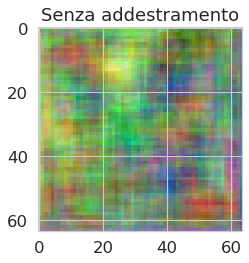

In [145]:
noise = tf.random.normal([1, 100])
plt.title('Senza addestramento')
generated_image = pokeGEN(noise, training=False)
img_test = keras.preprocessing.image.array_to_img(generated_image[0])
plt.imshow(img_test)

plt.tight_layout()

plt.show()

In [146]:
pokeGEN.load_weights('Weights/gen_weights_epoch_150.h5')
pokeDISC.load_weights('Weights/disc_weights_epoch_150.h5')

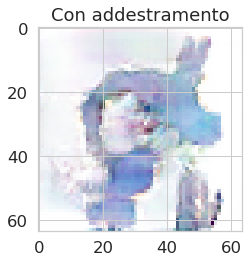

In [172]:
noise = tf.random.normal([1, 100])
plt.title('Con addestramento')
generated_image = pokeGEN(noise, training=False)
img_test = keras.preprocessing.image.array_to_img(generated_image[0])
plt.imshow(img_test)

plt.tight_layout()

plt.show()

### Test della CNN su dato generato

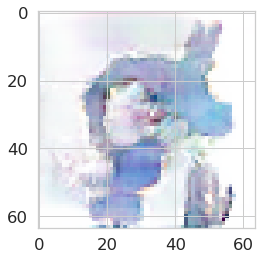

Rete Neurale Convoluzionale sceglie:  Moltres !!


In [173]:
predict_pokemon(cnn, img_test)

### Il risultato della run di 150 epoche, k=3

Ho salvato le immagini prodotte al termine di ogni epoca con il metodo `stampa_pokemon`, in modo da visualizzare l'evoluzione del grado di addestramento del generatore. I risultati sono rappresentati nella gif seguente

<img src='pokemon.gif' style="width: 800px;">

Non ho fatto un'analisi dell'errore nel caso della GAN poiché il mio intento era semplicemente generare immagini di pokemon per poter mettere alla prova la CNN addestrata nella prima parte del progetto. Un'indagine accurata in questo senso sarebbe opportuna. Nonostante questo, osservando le immagini prodotte, mi rendo conto che la pokeGAN non è sufficientemente addestrata (o complessa?) per sostenere un compito come quello di produrre immagini di 150 tipi di pokemon differenti. 

### Come lavora su un campione più semplice?

Per provare a rispondere a questa domanda ho deciso di sottoporre la stessa GAN ad un addestramento più breve ma su un campione di immagini di cani che, per quanto diversi tra loro, costituiscono un insieme di campionamento molto più omogeneo dell'insieme di pokemon trattato in questo lavoro.

<img src='cani.png' style="width: 700px;">

L'immagine, sebbene non rappresenti i cani in modo particolarmente realistico, dimostra che la complessità del campione di pokemon utilizzato sia una delle cause dei risultati ottenuti.

### Conclusioni 

- Nel corso del progetto ho preso familiarità con le reti neurali, in particolare le CNN, comprendendo l'utilità di diverse tipologie di strati latenti e l'importanza della scelta di funzione di costo e attivazione in problemi di classificazione. 
- A causa della scelta che ho fatto in merito al dataset e al numero di classi coinvolte non ho potuto approfondire lo studio dei tempi di convergenza della rete come avrei voluto; con insiemi più semplici (e quindi tempi di calcolo inferiori) sarebbe opportuno confrontare gli andamenti delle curve relative a funzione di costo e accuratezza di classificazione in funzione della scelta dell'ottimizzatore e dei parametri iniziali.
- Ho imparato che la struttura a strati di una rete in stile feed-forward può svolgere compiti profondamente diversi, dalla classificazione alla generazione di nuove immagini. 
- Avendo a disposizione un dataset variegato, contenente immagini molto diverse tra loro in forma e dimensione, ho potuto imparare alcuni meccanismi basilari di image-preprocessing, operazione fondamentale per preparare un sistema all'addestramento di reti neurali profonde.
- Per addestrare la GAN fino ad ottenere immagini interessanti ho utilizzato le GPU di Google, fornite dal servizio GoogleColab, imparando a conoscerne l'interfaccia e il funzionamento.

### Possibili miglioramenti al progetto

- Per migliorare le performance della GAN si potrebbe costruire un campione di immagini più omogeneo selezionando, ad esempio, figure di pokemon con lo stesso sfondo (bianco, nero) e generare immagini da uno spazio latente più semplice da suddividere in classi.
- Avendo a disposizione una maggior potenza di calcolo si potrebbe approfondire lo studio dei valori iniziali dei parametri, addestrando la CNN su numero maggiore di epoche per diverse combinazioni di parametri.
- Per quantificare la bontà raggiunta dal modello scelto come GAN occorrebbe effettuare uno studio dell'errore più approfondito, sottoponendo ad ogni epoca discriminatore e gan alla valutazione di una funzione di costo considerando il set di training e un set di test.

### Riferimenti bibliografici

[1] <a href="https://arxiv.org/pdf/1406.2661.pdf">*Generative Adversal Networks*, 2014, J.Goodfellow et al.</a>

[2] <a href="https://keras.io/">*Documentazione ufficiale Keras*</a>

[3] <a href="https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb">*Generating faces with GAN*, J. Heaton, Washington University</a>
    
[4] <a href="https://www.kaggle.com/lantian773030/pokemonclassification">*Dataset e indicazioni a cura di Lance Zhang*</a>

[5] <a href="https://gitlab.com/cbarbieri/MachineLearning-con-applicazioni/-/blob/master/README.md">*Materiale del corso di Machine-Learning e applicazioni del professor C. Barbieri, Università statale di Milano*</a>